# Empherical Testing on CIFAR-10 dataset

In [190]:
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from os import path
import numpy as np
import numpy as np
from PIL import Image
from tqdm import tqdm
import argparse
from torch import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
#import cv2
import sys
from skimage import segmentation
import torch.nn.init
from cv2 import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.measure import compare_ssim as ssim
from sklearn.metrics.cluster import adjusted_rand_score



In [67]:
#load input data CIFAR 
def Load_data(dataFile):
    #print("load datafile started")
    image_array=[]
    dim = (128,128)
    for label in (os.listdir(dataFile)):
        count=0
        for img in (os.listdir(os.path.join(dataFile, label))):
            count=count+1
            img_cat=[]

            img_read=cv2.imread(os.path.join(dataFile, label, img), cv2.IMREAD_UNCHANGED)
            img_read = cv2.resize(img_read, dim, interpolation = cv2.INTER_AREA)


            img_cat.append(img)
            img_cat.append(img_read)
            img_cat.append(label)
            image_array.append(img_cat)
            if(count==1):
                break
        break
    return image_array

In [68]:
#CNN model architecture (Conv + BatchNormalisation + Conv + BatchNormalisation)--> Initial Conv layer

class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.nChannel = 5
        self.nConv = 3
        self.conv1 = nn.Conv2d(input_dim, self.nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(self.nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        
        for i in range(self.nConv-1): #Adding extra Conv layers and BatchNormalisation to base architecture
            self.conv2.append( nn.Conv2d(self.nChannel,self.nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(self.nChannel) )
        self.conv3 = nn.Conv2d(self.nChannel, self.nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(self.nChannel)

    # Function working on the provided inputs to NN

    def forward(self, x): #x is the input shape
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(self.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x   #final output from network




In [92]:
#Function to perform segmentation
def Segmentation(image ,num_superpixels, compactness):

        #hyperparameters initialisation
        nChannel=5
        maxIter= 300
        min_clusters= 2   
        lr=0.1
        nConv=3
        num_superpixels= num_superpixels
        compactness= compactness
        visualize= 1 
    
        print("Segmentation started")
        #image_res= cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        
        #Input Image provided for Segmentation
        
        cv2.imshow( "input", image )
        cv2.waitKey(10)
        #plt.imshow(image)
                
        data = torch.from_numpy( np.array([image.transpose( (2, 0, 1) ).astype('float32')/255.]) )
        
        # slic to produce a ground truth to compare
        clusters = segmentation.slic(image, compactness=compactness, n_segments=num_superpixels)
        clusters = clusters.reshape(image.shape[0]*image.shape[1])  
        
        #number of unique labels by combining the values for all labels generated 
        unique_cluster = np.unique(clusters)
        l_inds = []
        for i in range(len(unique_cluster)):
            l_inds.append( np.where( clusters == unique_cluster[ i ] )[ 0 ] )
            
        # Training CNN model 
        model = MyNet( data.size(1) )  #data.size(1) is value 3 
        model.train()
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        label_colours = np.random.randint(255,size=(100,3))
        
        for _ in range(maxIter):
        # forwarding
            optimizer.zero_grad()
            output = model( data )[ 0 ]
            output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
            ignore, target = torch.max( output, 1 )
            im_target = target.data.cpu().numpy()
            #print(im_target)
            
            #check number of clusters 
            Num_clusters = len(np.unique(im_target))
            if visualize:
                im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
                im_target_rgb = im_target_rgb.reshape( image.shape ).astype( np.uint8 )
                #im_target_rgb_res= cv2.resize(im_target_rgb, dim, interpolation = cv2.INTER_AREA)
                cv2.imshow( "output", im_target_rgb )
                cv2.waitKey(10)
                

            # superpixel refinement
            for i in range(len(l_inds)):
                labels_per_sp = im_target[ l_inds[ i ] ]
                unique_labels_per_sp = np.unique( labels_per_sp )
                hist = np.zeros( len(unique_labels_per_sp) )
                for j in range(len(hist)):
                    hist[ j ] = len( np.where( labels_per_sp == unique_labels_per_sp[ j ] )[ 0 ] )
                im_target[ l_inds[ i ] ] = unique_labels_per_sp[ np.argmax( hist ) ]
            target = torch.from_numpy( im_target )
            target = Variable( target )
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            if Num_clusters <= min_clusters:
                break
        
        
        #Show Segmented Image after total iterations or minimum clusters are reached 
        cv2.imshow("Segmented image", im_target_rgb)
        cv2.waitKey(10)
        #plt.imshow (im_target_rgb)
        return (im_target_rgb)



In [70]:
#Function initialising segmentation
def start_segmentation(image_array):
    feature_list = []
    count=0
    save_path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\segmentation\\Segmentation_CNN\\segmented_mask_cifar\\'
    print("Starting segmentation")
    for i in range(len(image_array)):

        image=image_array[i][1]
        image_name = image_array[i][0]

        im=Segmentation(image)
        
        im_array=im.flatten()
        im=Image.fromarray(np.uint8(im)).convert('RGB')
        
        name,extension=path.splitext(image_name)
        im.save(save_path+name+'.png')

        row = [image_name,im_array,image_array[i][2]]
        feature_list.append(row)
        #count=count+1
        # if(count==5):
        #     break
        
    df = pd.DataFrame(feature_list, columns=["file_name", code ,"label"])
    pd.to_pickle(df, code+'.pkl')

#Function to compute similarity


In [42]:

#Inputs , segmentation , query image and similarity computation calls 

if __name__ == "__main__":    
    
    dataFile="C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\media\\cifar10"
    loaded_data=Load_data(dataFile)
    print("dataset Loaded")
    segmented_images = start_segmentation(loaded_data) 
    print("segmentation done")
    

dataset Loaded
Starting segmentation
Segmentation started
segmentation done


In [36]:

code='cifar_segment'


# Hyperparameter Setting based on segmentation quality 

## Sample Image 1 for experiments 

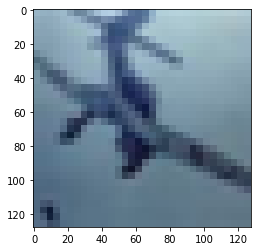

In [155]:
sample_image= 'C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\media\\cifar10\\airplane\\airplane_1147.png'
sample_image=cv2.imread(sample_image, cv2.IMREAD_UNCHANGED)
sample_image = cv2.resize(sample_image, (128,128), interpolation = cv2.INTER_AREA)
plt.imshow(sample_image)

### 1) High number of superpixels and low compactness

In [187]:
num_superpixels= 800
compactness= 10
visualize= 1 

In [188]:
segmented_sample_image = Segmentation(sample_image,num_superpixels,compactness)

Segmentation started


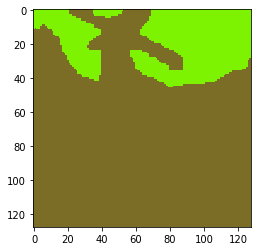

In [189]:
imgplot = plt.imshow(segmented_sample_image)


### 2) Low number of superpixels and high compactness

In [176]:
num_superpixels= 10
compactness= 1000
visualize= 1 

In [177]:
segmented_sample_image = Segmentation(sample_image,num_superpixels,compactness)

Segmentation started


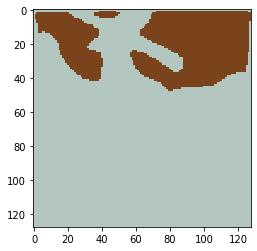

In [178]:
imgplot = plt.imshow(segmented_sample_image)

### 3) Low number of superpixels and very low value for compactness

In [181]:
num_superpixels= 10
compactness= 1
visualize= 1 

In [182]:
segmented_sample_image = Segmentation(sample_image,num_superpixels,compactness)

Segmentation started


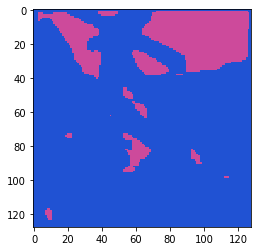

In [183]:
imgplot = plt.imshow(segmented_sample_image)

### 4) High number of superpixels and high value for compactness

In [184]:
num_superpixels= 1000
compactness= 100
visualize= 1 

In [185]:
segmented_sample_image = Segmentation(sample_image,num_superpixels,compactness)

Segmentation started


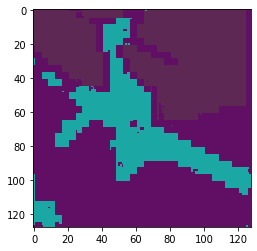

In [186]:
imgplot = plt.imshow(segmented_sample_image)

## Sample Image 2 with high superpixel and compactness values 

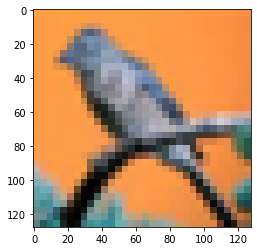

In [136]:
sample_image= 'C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\media\\cifar10\\bird\\bird_1072.png'
sample_image=cv2.imread(sample_image, cv2.IMREAD_UNCHANGED)
sample_image = cv2.resize(sample_image, (128,128), interpolation = cv2.INTER_AREA)
plt.imshow(sample_image)

Segmentation started


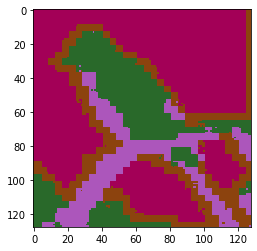

In [137]:
num_superpixels= 1000
compactness= 100
visualize= 1 
segmented_sample_image = Segmentation(sample_image,num_superpixels,compactness)
imgplot = plt.imshow(segmented_sample_image)

## Sample Image 2 with high superpixel and compactness values 

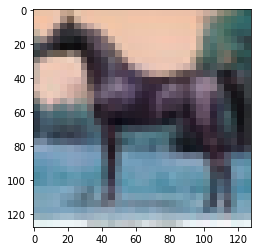

In [138]:
sample_image= 'C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\media\\cifar10\\horse\\horse_1074.png'
sample_image=cv2.imread(sample_image, cv2.IMREAD_UNCHANGED)
sample_image = cv2.resize(sample_image, (128,128), interpolation = cv2.INTER_AREA)
plt.imshow(sample_image)

Segmentation started


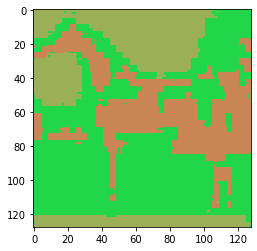

In [139]:
num_superpixels= 1000
compactness= 100
visualize= 1 
segmented_sample_image = Segmentation(sample_image,num_superpixels,compactness)
imgplot = plt.imshow(segmented_sample_image)

# Similarity Computation (Mask) without dimensionality Reduction

In [11]:
save_path ='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\segmentation\\Segmentation_CNN\\segmented_mask_cifar'

In [164]:
def Similarity(segmented_query_img):
    count=0
    similarity=[]
#     mask_query_img=np.array(mask_query_img)

    for img_file in tqdm(os.listdir(save_path)):
        img=cv2.imread(os.path.join(save_path,img_file), cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
        
        #print(type(img),type(segmented_query_img))
        
        sim_ssim = ssim(segmented_query_img, img,multichannel=True)
        sim_ari = adjusted_rand_score(segmented_query_img.flatten(),img.flatten())
    
        row=[img_file,sim_ari,sim_ssim]
        similarity.append(row)
    
    return similarity


In [165]:
query_path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\media\\cifar10\\airplane\\airplane_152.png'
query_img=cv2.imread(query_path, cv2.IMREAD_UNCHANGED)
query_img = cv2.resize(query_img, (128,128), interpolation = cv2.INTER_AREA)
segmented_query_img = Segmentation(query_img)

Segmentation started


In [ ]:
similarity=Similarity(segmented_query_img)

In [148]:
ari=[]
ssim=[]

for i in range(len(similarity)):
    label,extension=similarity[i][0].split('_')
    
    entry_ari=[similarity[i][0],similarity[i][1],label]
    entry_ssim=[similarity[i][0],similarity[i][2],label]
    ari.append(entry_ari)
    ssim.append(entry_ssim)
    

In [149]:
ari = sorted(ari , key=lambda ari:ari[1] ,reverse=True)
ssim = sorted(ssim , key=lambda ssim:ssim[1] ,reverse=True)

In [150]:
query='airplane_152.png'
query_label,ext= query.split('_')
print(query_label)

airplane


### Precision / Recall / F1-score 

In [ ]:
#top_k=[50,100,150,200,250]
top_k=[100,200,300,400,500]

precision_score_ari=[]
precision_score_ssim=[]

recall_score_ari=[]
recall_score_ssim=[]

f1_score_ari=[]
f1_score_ssim=[]

rel_ari=0
rel_ssim=0

for i in range(len(ari)):
    
    label_ari=ari[i][2]
    label_ssim=ssim[i][2]
    if(label_ari==query_label):
            rel_ari=rel_ari+1
    if(label_ssim==query_label):
            rel_ssim=rel_ssim+1

#print(rel_ari,rel_ssim)

for i in top_k:
    rel_ret_ari=0
    rel_ret_ssim=0
    for j in range(i):
        label_ari=ari[j][2]
        label_ssim=(ssim[j][2])
        if(label_ari == query_label):
            rel_ret_ari = rel_ret_ari+1
        if(label_ssim == query_label):
            rel_ret_ssim = rel_ret_ssim+1
            
   # print (rel_ret_ari,rel_ret_ssim)
    
    precision_ari = rel_ret_ari/i
    precision_ssim = rel_ret_ssim/i
    
    recall_ari = rel_ret_ari/rel_ari
    recall_ssim = rel_ret_ssim/rel_ssim
    
    f1_ari = ((2*precision_ari*recall_ari)/(precision_ari+recall_ari))
    f1_ssim = ((2*precision_ssim * recall_ssim)/(precision_ssim + recall_ssim))
    
    precision_score_ari.append(precision_ari)
    precision_score_ssim.append(precision_ssim)
    
    recall_score_ari.append(recall_ari)
    recall_score_ssim.append(recall_ssim)
    
    f1_score_ari.append(f1_ari)
    f1_score_ssim.append(f1_ssim)
    
    
print("precision",precision_score_ari,precision_score_ssim)
print("recall",recall_score_ari,recall_score_ssim)
print("f1score",f1_score_ari,f1_score_ssim)
            

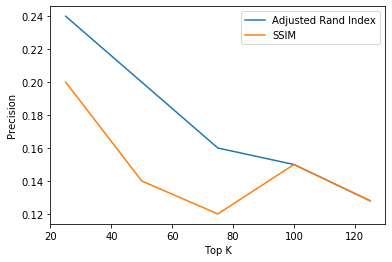

In [152]:
plt.figure("Precision")
plt.xlabel('Top K')
plt.ylabel('Precision')
plt.plot(top_k, precision_score_ari)
plt.plot(top_k, precision_score_ssim)

plt.legend(["Adjusted Rand Index", "SSIM"])

plt.show()


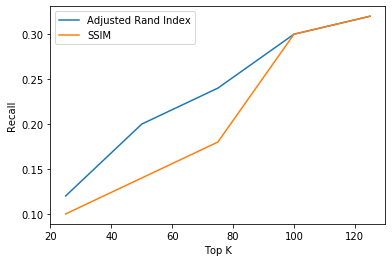

In [153]:

plt.figure("Recall")
plt.xlabel('Top K')
plt.ylabel('Recall')
plt.plot(top_k, recall_score_ari)
plt.plot(top_k, recall_score_ssim)

plt.legend(["Adjusted Rand Index", "SSIM"])

plt.show()


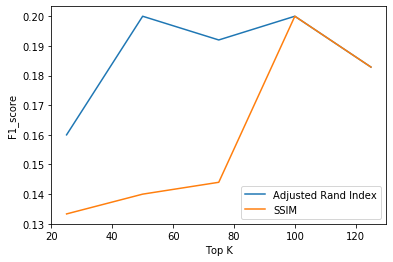

In [154]:

plt.figure("F1 Score")
plt.xlabel('Top K')
plt.ylabel('F1_score')
plt.plot(top_k, f1_score_ari)
plt.plot(top_k, f1_score_ssim)

plt.legend(["Adjusted Rand Index", "SSIM"])

plt.show()


# Similarity Computation after Dimensionality reduction  

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import scipy.io as sio
import matplotlib.image as image
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
def Similarity_pca(segmented_query_img):
    count=0
    similarity=[]
#     mask_query_img=np.array(mask_query_img)

    pca = PCA(n_components=13)   #2 5 7 10 13
    
    print(type(segmented_query_img))
    segmented_query_img = np.resize(segmented_query_img,(128,128))
    segmented_query_img = np.array(segmented_query_img)
    segmented_query_img_norm = normalize(segmented_query_img)
    segmented_query_img = pca.fit_transform(segmented_query_img_norm)

    for img_file in tqdm(os.listdir(save_path)):
        img=cv2.imread(os.path.join(save_path,img_file), cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
        img = np.resize(img,(128,128))
        
        print(img.shape,type(img))
        
        img = np.array(img)
        img_norm = normalize(img)
        img = pca.fit_transform(img_norm)
        
        sim_ssim = ssim(np.array(segmented_query_img), np.array(img),multichannel=True)
        sim_ari = adjusted_rand_score(segmented_query_img.flatten(),img.flatten())
    
        row=[img_file,sim_ari,sim_ssim]
        similarity.append(row)
    
    return similarity


In [9]:
dim=(128,128)
query='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\media\\cifar10\\airplane\\airplane_152.png'
query=cv2.imread(query, cv2.IMREAD_UNCHANGED)
query = cv2.resize(query, dim, interpolation = cv2.INTER_AREA)
print(query.shape,type(query))
segmented_query_img = Segmentation(query)

(128, 128, 3) <class 'numpy.ndarray'>
Segmentation started


In [ ]:
similarity_pca=Similarity_pca(segmented_query_img)

In [45]:
ari_pca=[]
ssim_pca=[]

for i in range(len(similarity_pca)):
    label,extension=similarity_pca[i][0].split('_')
    
    entry_ari=[similarity_pca[i][0],similarity_pca[i][1],label]
    entry_ssim=[similarity_pca[i][0],similarity_pca[i][2],label]
    ari_pca.append(entry_ari)
    ssim_pca.append(entry_ssim)

In [46]:
ari_pca = sorted(ari_pca , key=lambda ari:ari[1] ,reverse=True)
ssim_pca = sorted(ssim_pca , key=lambda ssim:ssim[1] ,reverse=True)

In [47]:
query='airplane_152.png'
query_label,ext= query.split('_')
print(query_label)

airplane


### Precision / Recall / F1score with PCA components = 2

In [48]:
#top_k=[50,100,150,200,250]
top_k=[100,200,300,400,500]

precision_score_ari_pca=[]
precision_score_ssim_pca=[]

recall_score_ari_pca=[]
recall_score_ssim_pca=[]

f1_score_ari_pca=[]
f1_score_ssim_pca=[]

rel_ari_pca=0
rel_ssim_pca=0

for i in range(len(ari_pca)):
    
    label_ari=ari_pca[i][2]
    label_ssim=ssim_pca[i][2]
    if(label_ari==query_label):
            rel_ari_pca = rel_ari_pca + 1
    if(label_ssim==query_label):
            rel_ssim_pca = rel_ssim_pca + 1

#print(rel_ari,rel_ssim)

for i in top_k:
    rel_ret_ari_pca=0
    rel_ret_ssim_pca=0
    for j in range(i):
        label_ari=ari_pca[j][2]
        label_ssim=(ssim_pca[j][2])
        if(label_ari == query_label):
            rel_ret_ari_pca = rel_ret_ari_pca+1
        if(label_ssim == query_label):
            rel_ret_ssim_pca = rel_ret_ssim_pca+1
            
   # print (rel_ret_ari,rel_ret_ssim)
    
    precision_ari_pca = rel_ret_ari_pca/i
    precision_ssim_pca = rel_ret_ssim_pca/i
    
    recall_ari_pca = rel_ret_ari_pca/rel_ari_pca
    recall_ssim_pca = rel_ret_ssim_pca/rel_ssim_pca
    
    f1_ari_pca = ((2*precision_ari_pca*recall_ari_pca)/(precision_ari_pca+recall_ari_pca))
    f1_ssim_pca = ((2*precision_ssim_pca * recall_ssim_pca)/(precision_ssim_pca + recall_ssim_pca))
    
    precision_score_ari_pca.append(precision_ari_pca)
    precision_score_ssim_pca.append(precision_ssim_pca)
    
    recall_score_ari_pca.append(recall_ari_pca)
    recall_score_ssim_pca.append(recall_ssim_pca)
    
    f1_score_ari_pca.append(f1_ari_pca)
    f1_score_ssim_pca.append(f1_ssim_pca)
    
    
print("precision",precision_score_ari_pca,precision_score_ssim_pca)
print("recall",recall_score_ari_pca,recall_score_ssim_pca)
print("f1score",f1_score_ari_pca,f1_score_ssim_pca)
            

precision [0.45, 0.415, 0.37333333333333335, 0.345, 0.334] [0.34, 0.305, 0.3433333333333333, 0.3325, 0.336]
recall [0.09, 0.166, 0.224, 0.276, 0.334] [0.068, 0.122, 0.206, 0.266, 0.336]
f1score [0.15, 0.23714285714285718, 0.27999999999999997, 0.30666666666666664, 0.334] [0.11333333333333333, 0.1742857142857143, 0.25749999999999995, 0.29555555555555557, 0.336]


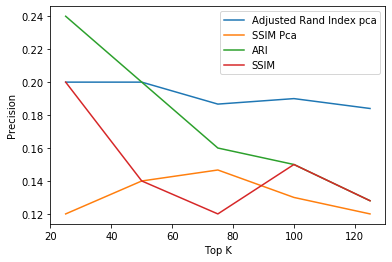

In [155]:
plt.figure("Precision_PCA")
plt.xlabel('Top K')
plt.ylabel('Precision')
plt.plot(top_k, precision_score_ari_pca)
plt.plot(top_k, precision_score_ssim_pca)
plt.plot(top_k, precision_score_ari)
plt.plot(top_k, precision_score_ssim)

plt.legend(["Adjusted Rand Index pca", "SSIM Pca","ARI","SSIM"])

plt.show()

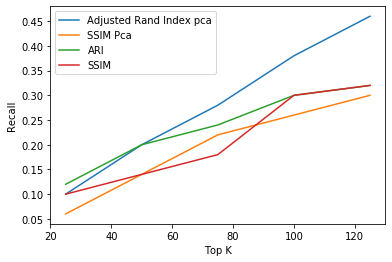

In [156]:
plt.figure("Recall_PCA")
plt.xlabel('Top K')
plt.ylabel('Recall')
plt.plot(top_k, recall_score_ari_pca)
plt.plot(top_k, recall_score_ssim_pca)
plt.plot(top_k, recall_score_ari)
plt.plot(top_k, recall_score_ssim)

plt.legend(["Adjusted Rand Index pca", "SSIM Pca","ARI","SSIM"])

plt.show()

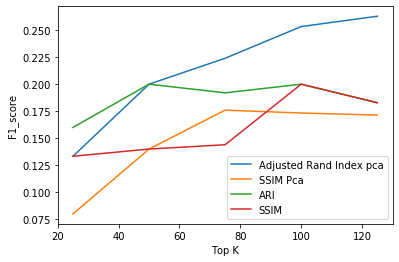

In [157]:

plt.figure("F1 Score PCA")
plt.xlabel('Top K')
plt.ylabel('F1_score')
plt.plot(top_k, f1_score_ari_pca)
plt.plot(top_k, f1_score_ssim_pca)
plt.plot(top_k, f1_score_ari)
plt.plot(top_k, f1_score_ssim)


plt.legend(["Adjusted Rand Index pca", "SSIM Pca","ARI","SSIM"])

plt.show()


### Precision / Recall / F1-score with PCA components 2/5/7/10/13

In [21]:
precision_score_ari_pca_2 , precision_score_ssim_pca_2 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_2 , recall_score_ssim_pca_2 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_2 , f1_score_ssim_pca_2 = f1_score_ari_pca , f1_score_ssim_pca

In [28]:
precision_score_ari_pca_5 , precision_score_ssim_pca_5 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_5 , recall_score_ssim_pca_5 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_5 , f1_score_ssim_pca_5 = f1_score_ari_pca , f1_score_ssim_pca

In [35]:
precision_score_ari_pca_7 , precision_score_ssim_pca_7 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_7 , recall_score_ssim_pca_7 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_7 , f1_score_ssim_pca_7 = f1_score_ari_pca , f1_score_ssim_pca

In [42]:
precision_score_ari_pca_10 , precision_score_ssim_pca_10 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_10 , recall_score_ssim_pca_10 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_10 , f1_score_ssim_pca_10 = f1_score_ari_pca , f1_score_ssim_pca

In [49]:
precision_score_ari_pca_13 , precision_score_ssim_pca_13 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_13 , recall_score_ssim_pca_13 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_13 , f1_score_ssim_pca_13 = f1_score_ari_pca , f1_score_ssim_pca

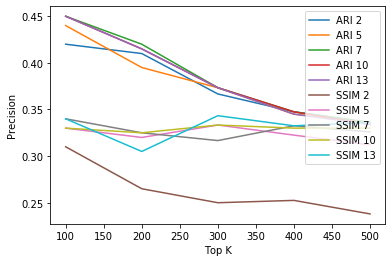

In [52]:
plt.figure("Precision_PCA")
plt.xlabel('Top K')
plt.ylabel('Precision')
plt.plot(top_k, precision_score_ari_pca_2)
plt.plot(top_k, precision_score_ari_pca_5)
plt.plot(top_k, precision_score_ari_pca_7)
plt.plot(top_k, precision_score_ari_pca_10)
plt.plot(top_k, precision_score_ari_pca_13)

plt.plot(top_k, precision_score_ssim_pca_2)
plt.plot(top_k, precision_score_ssim_pca_5)
plt.plot(top_k, precision_score_ssim_pca_7)
plt.plot(top_k, precision_score_ssim_pca_10)
plt.plot(top_k, precision_score_ssim_pca_13)

plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"],loc=1)

plt.show()




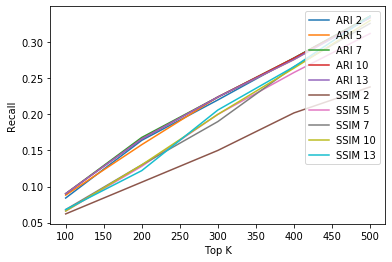

In [54]:


plt.figure("Recall_PCA")
plt.xlabel('Top K')
plt.ylabel('Recall')
plt.plot(top_k, recall_score_ari_pca_2)
plt.plot(top_k, recall_score_ari_pca_5)
plt.plot(top_k, recall_score_ari_pca_7)
plt.plot(top_k, recall_score_ari_pca_10)
plt.plot(top_k, recall_score_ari_pca_13)

plt.plot(top_k, recall_score_ssim_pca_2)
plt.plot(top_k, recall_score_ssim_pca_5)
plt.plot(top_k, recall_score_ssim_pca_7)
plt.plot(top_k, recall_score_ssim_pca_10)
plt.plot(top_k, recall_score_ssim_pca_13)

plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"],loc=1)

plt.show()



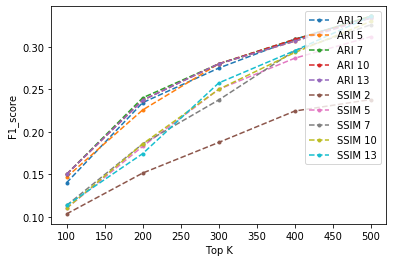

In [61]:
plt.figure("F1 Score PCA")
plt.xlabel('Top K')
plt.ylabel('F1_score')
plt.plot(top_k, f1_score_ari_pca_2,marker='.',linestyle='dashed')
plt.plot(top_k, f1_score_ari_pca_5,marker='.',linestyle='dashed')
plt.plot(top_k, f1_score_ari_pca_7,marker='.',linestyle='dashed')
plt.plot(top_k, f1_score_ari_pca_10,marker='.',linestyle='dashed')
plt.plot(top_k, f1_score_ari_pca_13,marker='.',linestyle='dashed')

plt.plot(top_k, f1_score_ssim_pca_2,marker='.',linestyle='dashed')
plt.plot(top_k, f1_score_ssim_pca_5,marker='.',linestyle='dashed')
plt.plot(top_k, f1_score_ssim_pca_7,marker='.',linestyle='dashed')
plt.plot(top_k, f1_score_ssim_pca_10,marker='.',linestyle='dashed')
plt.plot(top_k, f1_score_ssim_pca_13,marker='.',linestyle='dashed')


plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"],loc=1)

plt.show()